# Anaysis pipeline of _D. novamexicana_ post-mating RNAseq 

## Introduction

(Some blurb here about the project goals, sample prep, etc.)

### Load packages and generate some useful functions

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. The packages can be defined and loaded like so:

In [1]:
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", 
                 "VennDiagram")

lapply(req_packages, require, character.only = TRUE)

# The Cowplot package changes the default themes of ggplot2. Set the default theme like so:
theme_set(theme_gray())

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignette

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

[[24]]
[1] TRUE

[[25]]
[1] TRUE

[[26]]
[1] TRUE

[[27]]
[1] TRUE

The functions used in the analyses are in the file "Functions2.R":

In [2]:
source("Functions2.R")

These functions include: 
  * `MA_Bplot`: a function for generating MA plots and histograms of genes above 2-fold abundance
  * `plotGenePM`: for plotting mean±s.e TPM expression barplots (plotGenePM_RT plots Reproductive Tract expression only)
  * `plotHeatmap`: generic plotter for heatmaps with ggplot (requires matrix)
  * `calcSpecificity`: a function for calculating gene-wise tissue-specificity
  * `geneLookupG`: a function for extracting Trinotate annotations
  * `heatmap3`: for plotting heatmaps
  * ... and other miscellaneous RNAseq and R functions

### Load annotations, PAML data and orthology information

Some annotation files were generated from the _D. virilis_ transcriptome—in addition to miscellaneous population genetic data from the species group—that can be used here to annotate transcripts at various stages of the analysis. Load that data and process it for further use.

#### Annotations:
A Trinotate report and accompanying Gene Ontology assignments were produced in an earlier study that can be used here:

In [3]:
grpTrinotate = read.csv("Annotations/Trinotate_report_dvir1.06_subset.txt", header = T, sep = "\t", na.strings = ".", stringsAsFactors=FALSE)
GO_info = read.table("Annotations/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)

Another useful annotation file is the gene features file:

In [4]:
gffRecord = read.table("Annotations/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we can obtain information on orthology to _D. melanogaster_:

In [5]:
melOrths = read.table(file = "Annotations/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)

Finally, we can combine the files above for convenience:

In [6]:
Annots = merge(merge(melOrthsAll, grpTrinotate, all=TRUE), gffRecord, all=TRUE)

#### PAML data

Also from the previous RNAseq study on the virilis sub-group, some PAML and Ka/Ks results can be used here:

In [7]:
tmp.FB.names = unique(subset(Annots, select=c("FBgn_ID", "FBtr_ID")))
paml.data = read.csv(file = "Annotations/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
paml.data = merge(tmp.FB.names, paml.data, all=T)
paml.data = merge(gffRecord, paml.data, all=T)
KaKs.data = read.csv(file = "Annotations/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)
KaKs.data = merge(tmp.FB.names, KaKs.data, all=T)
KaKs.data = merge(gffRecord, KaKs.data, all=T)

We can combine gene names and descriptions with FBgn ID's in a 1:1 mapping to use in platting functions later.

In [76]:
ann.sum = unique(subset(Annots, select=c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description")))
ann.sum = aggregate(SwissProt_BlastX_Description ~ FBgn_ID + gene_name, data = ann.sum, toString)
lengt

[1] 10250

### Load expression matrices:

The raw counts from each sample obtained from `eXpress` can be loaded as a data-frame:

In [8]:
countsMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.counts.matrix", header=T, row.names=1, com='', check.names=F)

The normalized expression values—expressed in TPM units—can also be loaded as a data-frame:

In [9]:
tpmMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

Finally, a table of aggregate gene number by minimum TPM is usefull to estimate the number of expressed genes in the dataset:

In [10]:
cbmtMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.TPM.not_cross_norm.counts_by_min_TPM", header = T)

#### Read in sample information: 

The `samples.txt` and `SamplesInfo.txt` files describe the replicate:sample mapping and additional sample information:

In [11]:
sampleData = read.table("ExpressionData/samples.txt", header=F, check.names=F, fill=T)
sampleData = DnovPM.Samples_data[DnovPM.Samples_data[,2] != '',]
sampleInfo = read.table("ExpressionData/SampleInfo.txt", header=T, check.names=F, fill=T)

## Quality Control:-

##### Barplot of library size

After read trimming and filtering out low quality reads, we can check the library sizes of the samples to see if we satisfy the 10-20 million read minimum:

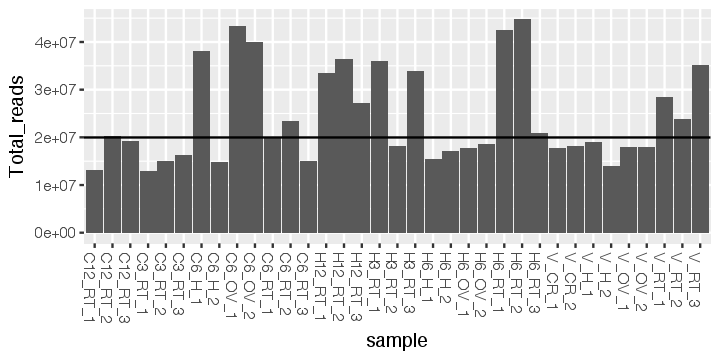

In [12]:
libSizes <- as.data.frame(colSums(countsMatrix))
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Total_reads")
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(libSizes, aes(sample, Total_reads)) + 
    geom_bar(stat="identity") + 
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000)

Looks like all the samples have >10 million reads, so the read counts look OK.

##### Boxplot of log10(TPM) across samples

To get a sense for broad expression patterns across samples, we can generate boxplots of TPM expression across samples to see if there are large median differences between samples/replicates:

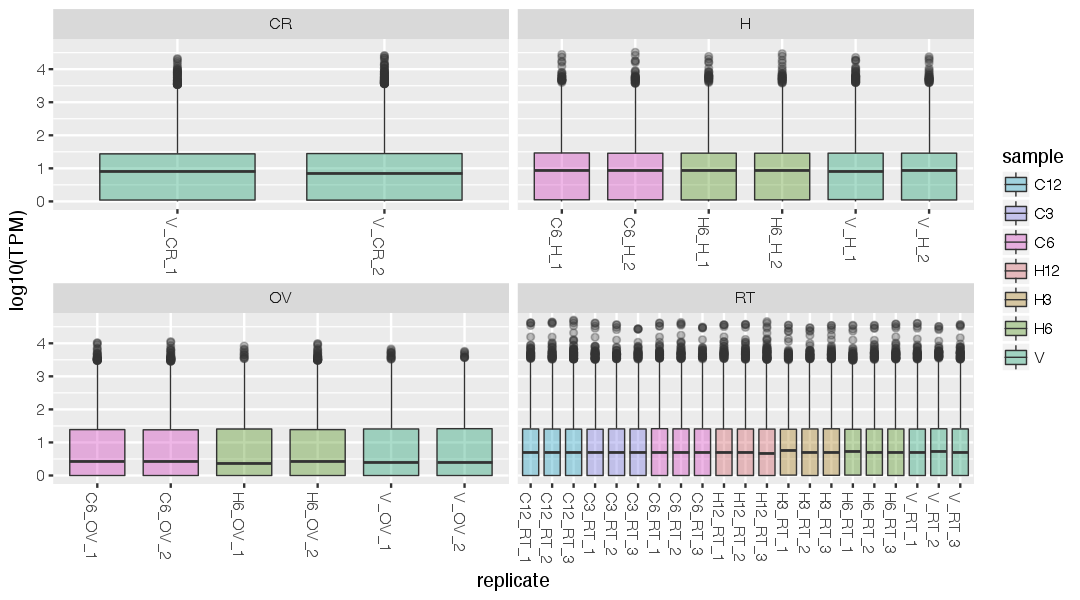

In [13]:
m.expData<-melt(as.matrix(tpmMatrix))
colnames(m.expData) <- c("gene_id", "replicate", "TPM")
m.expData.exp<- within(m.expData, replicate<-data.frame(do.call('rbind', strsplit(as.character(replicate),'_',fixed=TRUE))))
m.expData<-data.frame(m.expData, m.expData.exp$replicate$X1, m.expData.exp$replicate$X2, m.expData.exp$replicate$X3)
colnames(m.expData) <- c("gene_id", "replicate", "TPM", "sample", "tissue", "rep_num")
m.expData$TPM <- m.expData$TPM + 1
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(m.expData) + 
    geom_boxplot(aes(x = replicate, y = log10(TPM), fill = sample), size = 0.3, alpha = I(1/3)) + 
    facet_wrap(~tissue, scales = "free_x") +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    scale_fill_hue(l = 50, h.start = 200)

This is almost useless, but shows that all samples have roughly the same median expression values and similar spread across genes. We'll generate boxplots of normalized log2 counts for subsetted tissue matrices later.

##### Estimate of the number of expressed genes (Brian Haas' method) 

Several approaches can be used to filter out genes with little to no expression. This step is necessary because it reduces the potential for false-positives and improves the strength of detecting differentially expressed genes. One approach that Brian Haas uses with _de novo_ assembled transcripts (which have lots of garbage transcripts) is to plot the aggregate number of genes as a function of minimum TPM. Towards low TPM values, the curve expands and inflates the true number of expressed genes. Thus, fitting a line along the curve provides a reasonable estimate of the true number of expressed genes as the value of the y-intercept.

To accomplish this, we first extract the "trully expressed genes" (in this case, between 10 and 100 TPM):

In [14]:
cbmt.sub = cbmtMatrix[cbmtMatrix[,1] > -100 & cbmtMatrix[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [15]:
cbmt.sub_fit = lm(cbmt.sub[,2] ~ cbmt.sub[,1])
print(cbmt.sub_fit)


Call:
lm(formula = cbmt.sub[, 2] ~ cbmt.sub[, 1])

Coefficients:
  (Intercept)  cbmt.sub[, 1]  
       9185.3           69.4  



We can also plot the curve and linear fit:

Warning message:
"Removed 948 rows containing missing values (geom_point)."

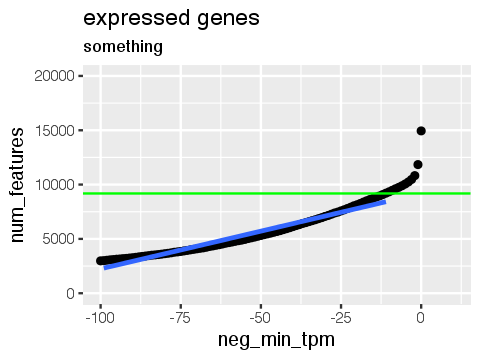

In [16]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(cbmtMatrix, aes(neg_min_tpm,num_features)) + 
    geom_point() +  
    scale_x_continuous(limits=c(-100,10)) + 
    scale_y_continuous(limits=c(0,20000)) + 
    geom_smooth(data=DnovPM_filt_data, method = "lm") + 
    geom_hline(yintercept = 9185, colour = "green") + ggtitle("expressed genes", subtitle = "something")

Out of ~1500 genes, roughly 9000 should remain after filtering lowly expressed geenes. Filtering should be performed on subsetted matrices for each analysis later, but here's the filter applied on the whole matrix. First, obtain the counts per million "CPM" matrix: 

In [17]:
all.CPM <- cpm(countsMatrix)

For now, let's set the minimum CPM to 1, and generate a logical matrix for CPM > 1:

In [18]:
thresh <- all.CPM > 1

We can see how many TRUEs there are in each row:

In [19]:
table(rowSums(thresh))


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3998  150  273  164   97   88  401  152  355  162   82   54   65   38   53   42 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
  54   30   28   36   29   85   35   49   45   40   26   78   74  599  117   66 
  32   33   34   35 
  66   83  131 7099 

We would like to keep genes that have at least 2 TRUEs in each row of `thresh`:

In [20]:
keep <- rowSums(thresh) >= 2

Now we subset the rows of the counts matrix to keep genes that satisfy our filter, then check how many genes are left:

In [21]:
counts.keep <- DnovPM.dvir1.06.CountsMatrix[keep,]
dim(counts.keep)

[1] 10796    35

## Differential expression analysis

### Virgin tissue contrasts:

The goal of this part of the analysis is to identify transcripts that show tissue-biased expression. We'll set a stringent cut-off of log 2-fold and a _p_-value of 0.001. 

First we'll subset the count matrix to only include virgin tissue samples:

In [22]:
countsMatrix.virgin = subset(countsMatrix, select=grepl("^V", colnames(countsMatrix)))
head(countsMatrix.virgin)

,V_CR_1,V_CR_2,V_H_1,V_H_2,V_OV_1,V_OV_2,V_RT_1,V_RT_2,V_RT_3
FBgn0202928,3232.66,3082.93,3879.65,2595.06,1520.47,1293.97,1092.88,863.67,1396.54
FBgn0199886,0.00,0.00,5.05,5.10,0.00,0.00,0.00,0.00,0.00
FBgn0199563,520.27,645.77,442.95,353.21,689.31,570.83,631.27,559.54,715.31
FBgn0211236,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FBgn0206588,1251.06,929.85,1578.18,1563.96,3505.96,3700.23,1992.25,1559.37,2273.14
FBgn0211037,47.61,30.46,66.80,28.85,150.51,114.51,88.10,75.31,109.11


Now we can filter out low expression genes with a minimum 5 cpm cutoff:

In [23]:
cpmMatrix.virgin <- cpm(countsMatrix.virgin)
v.thresh <- cpmMatrix.virgin > 5
## look at number of columns with above requirements
table(rowSums(v.thresh))

v.keep <- rowSums(v.thresh) >= 3
countsMatrix.virgin.filt <- countsMatrix.virgin[v.keep,]
## Check how many genes remain in the matrix.
dim(countsMatrix.virgin.filt)


   0    1    2    3    4    5    6    7    8    9 
5057  167 1219  554  488  274  218  841  290 5836 

[1] 8501    9

The filtered matrix contains 9720 genes. Let's see what the # cpm cutoff corresponds to in counts (looking at just one of the samples):

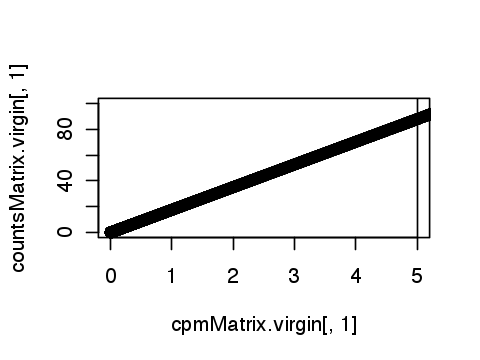

In [24]:
# Let's look at the first column
plot(cpmMatrix.virgin[,1],countsMatrix.virgin[,1],ylim=c(0,100),xlim=c(0,5))
# Add a vertical line at 5 CPM
abline(v=5)

Looks like 5 cpm corresponds to 60-100 mapped reads.

We'll also subset the `samplesData` object to only include the virgin tissue samples:

In [25]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")
sampleInfo.v

,SampleName,Replicate,Tissue,Status,time
27,V_CR,V_CR_1,carcass,virgin,0hpm
28,V_CR,V_CR_2,carcass,virgin,0hpm
29,V_H,V_H_1,head,virgin,0hpm
30,V_H,V_H_2,head,virgin,0hpm
31,V_OV,V_OV_1,ovaries,virgin,0hpm
32,V_OV,V_OV_2,ovaries,virgin,0hpm
33,V_RT,V_RT_1,repTract,virgin,0hpm
34,V_RT,V_RT_2,repTract,virgin,0hpm
35,V_RT,V_RT_3,repTract,virgin,0hpm


We can now define groups for differential expression:

In [47]:
groups.v = factor(sampleInfo.v$Tissue)
design.v = model.matrix( ~ 0 + groups.v)
colnames(design.v) <- levels(groups.v)
rownames(design.v) <- sampleInfo.v$Replicate
design.v

,carcass,head,ovaries,repTract
V_CR_1,1,0,0,0
V_CR_2,1,0,0,0
V_H_1,0,1,0,0
V_H_2,0,1,0,0
V_OV_1,0,0,1,0
V_OV_2,0,0,1,0
V_RT_1,0,0,0,1
V_RT_2,0,0,0,1
V_RT_3,0,0,0,1


Now we'll create the `DGE` object and fit the general linear model:

In [48]:
dgeList.v <- DGEList(counts = countsMatrix.virgin.filt, group = groups.v)
dgeList.v <- calcNormFactors(dgeList.v)
dgeList.v <- estimateCommonDisp(dgeList.v)
dgeList.v <- estimateTagwiseDisp(dgeList.v)

# We'll call this here, but will use it later to test for differential expression.
dgeList.v_fit <- glmFit(dgeList.v, design.v)

We can look at what's contained in the DGE object

In [49]:
names(dgeList.v)

[1] "counts"             "samples"            "common.dispersion" 
 [4] "pseudo.counts"      "pseudo.lib.size"    "AveLogCPM"         
 [7] "prior.df"           "prior.n"            "tagwise.dispersion"
[10] "span"

And a summary of tagwise disperion

In [50]:
summary(dgeList.v$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01758 0.02442 0.02920 0.04268 0.03762 1.80300 

We can plot the biological coefficient of variation to examine variability within each sample. It would also be useful to generatea `voom` object as an aside to check compare to the edgeR analyses (from this objectm we can look at the mean-variance trend). Also, let's generate a QQ-plot.

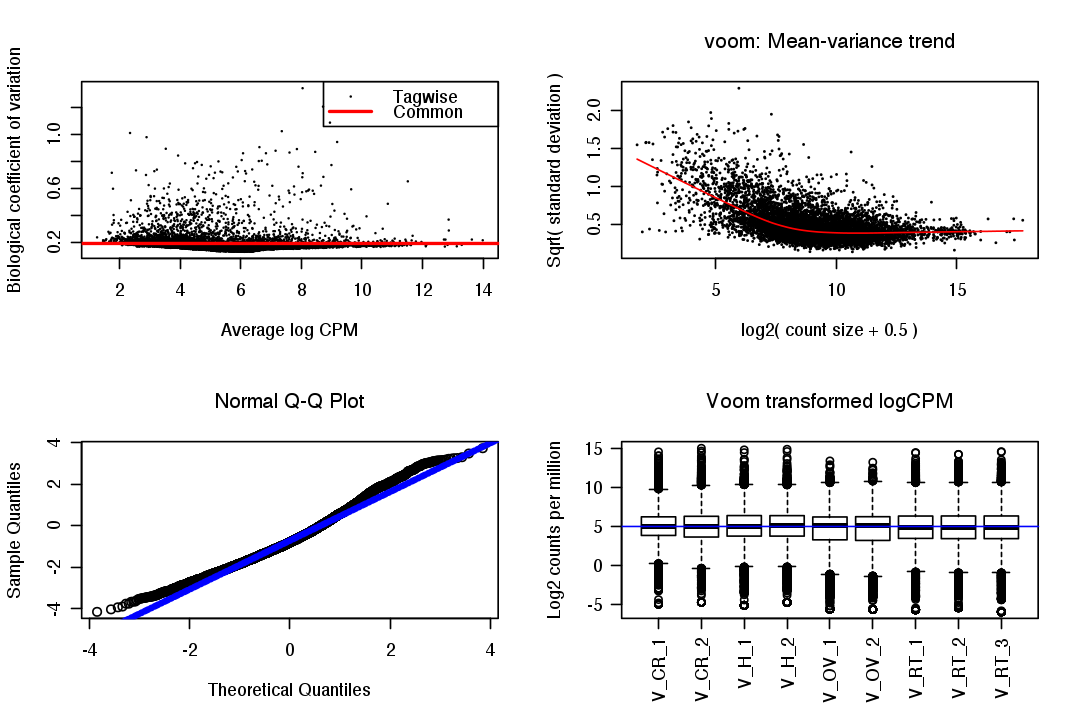

In [51]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.v)
# mean-variance trend
virgin.voom = voom(dgeList.v, design.v, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList.v_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=4,lty=4)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try '`method = "bcv"`' for a different type of grouping):

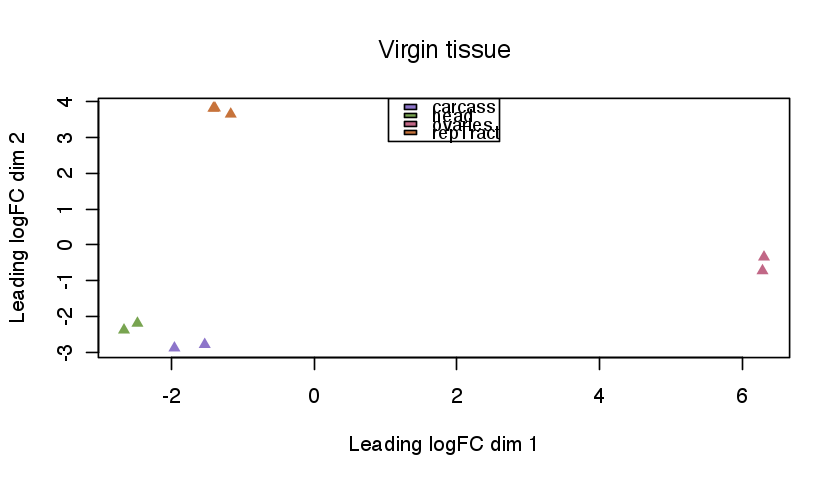

In [70]:
## colour samples by tissue-type
col.tissue <- c("#8d75ca","#78a450","#c16786","#c7733b")[sampleInfo.v$Tissue]
options(repr.plot.width = 7, repr.plot.height = 4)
plotMDS(dgeList.v, col=col.tissue, pch= 17, cex = 1)
legend("top",fill=c("#8d75ca","#78a450","#c16786","#c7733b"),legend=levels(sampleInfo.v$Tissue), cex = 0.85)
# Add a title
title("Virgin tissue")

Samples are grouping correctly, although the head and carcass samples appear to be fairly similar. Another way to look at grouping is by looking at sample correlations:

for plotting:: min.raw: 0.215679189957847 max.raw: 1


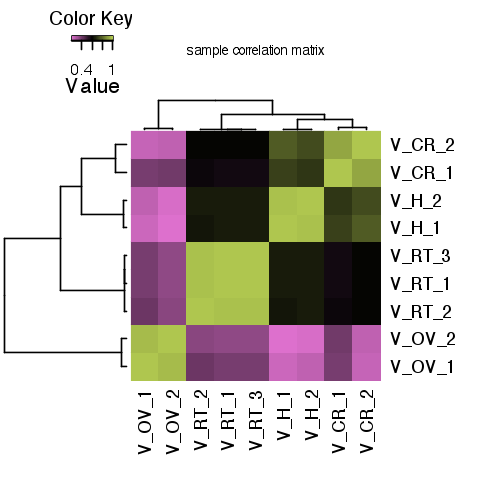

In [53]:
## Plot sample correlation
data = log2(countsMatrix.virgin.filt+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 4, repr.plot.height = 4)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Finally, let's compare replicates within each sample using MA plots:

Warning message:
"Removed 9 rows containing missing values (position_stack)."Warning message:
"Removed 6 rows containing missing values (geom_point)."

Warning message:
"Removed 12 rows containing missing values (position_stack)."Warning message:
"Removed 31 rows containing missing values (geom_point)."

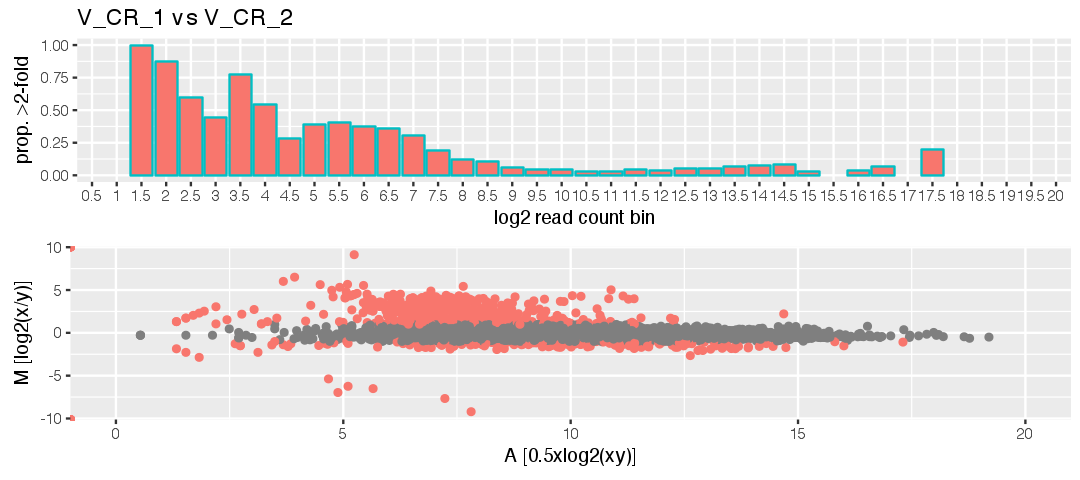

Warning message:
"Removed 10 rows containing missing values (position_stack)."Warning message:
"Removed 184 rows containing missing values (geom_point)."

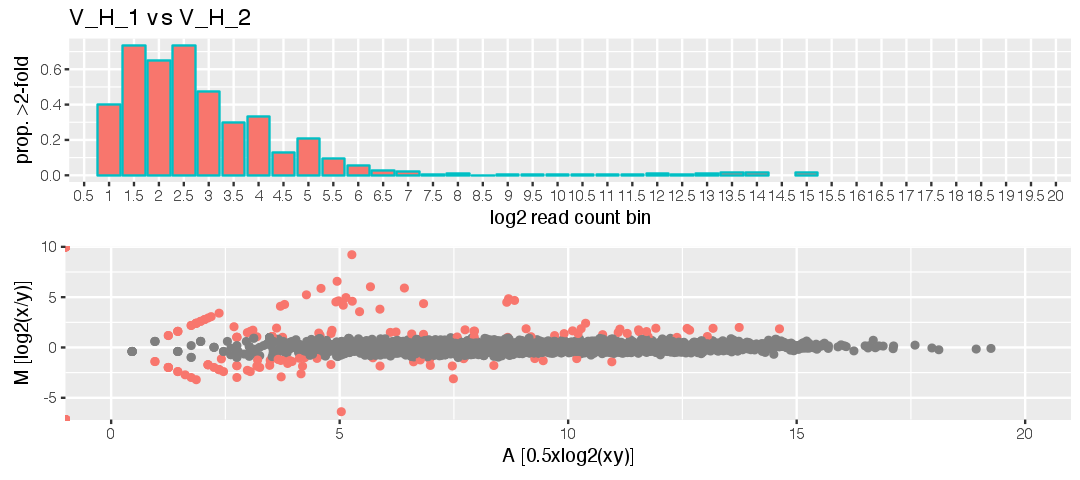

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 55 rows containing missing values (geom_point)."

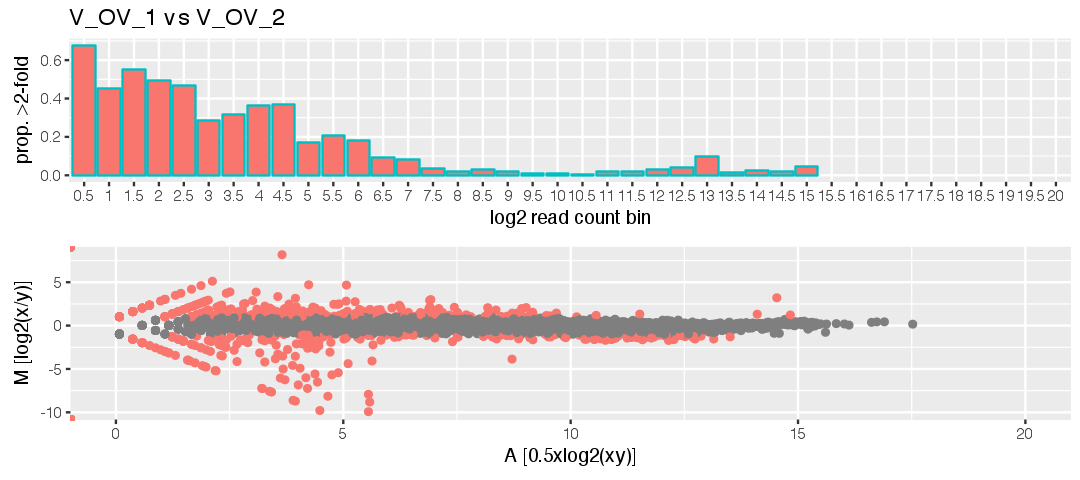

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 77 rows containing missing values (geom_point)."

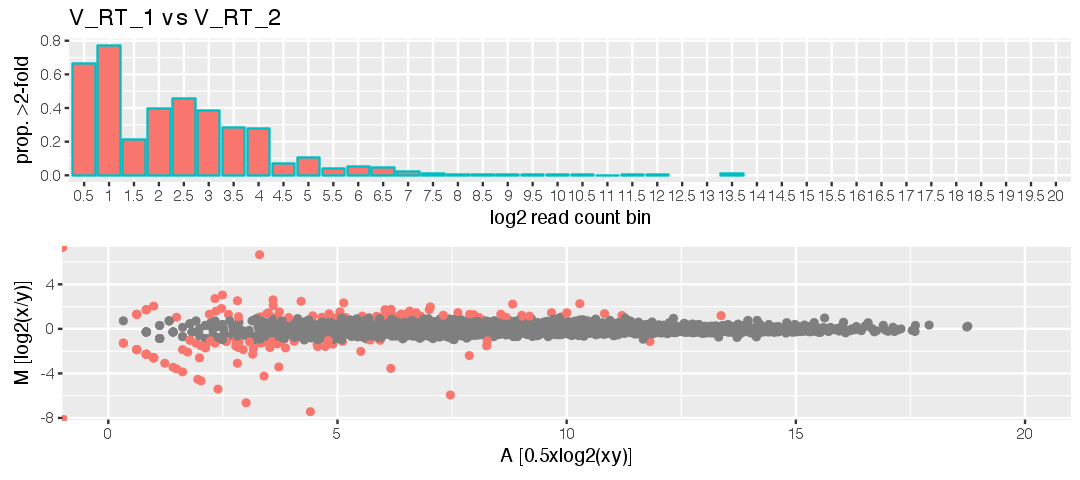

Warning message:
"Removed 17 rows containing missing values (position_stack)."Warning message:
"Removed 56 rows containing missing values (geom_point)."

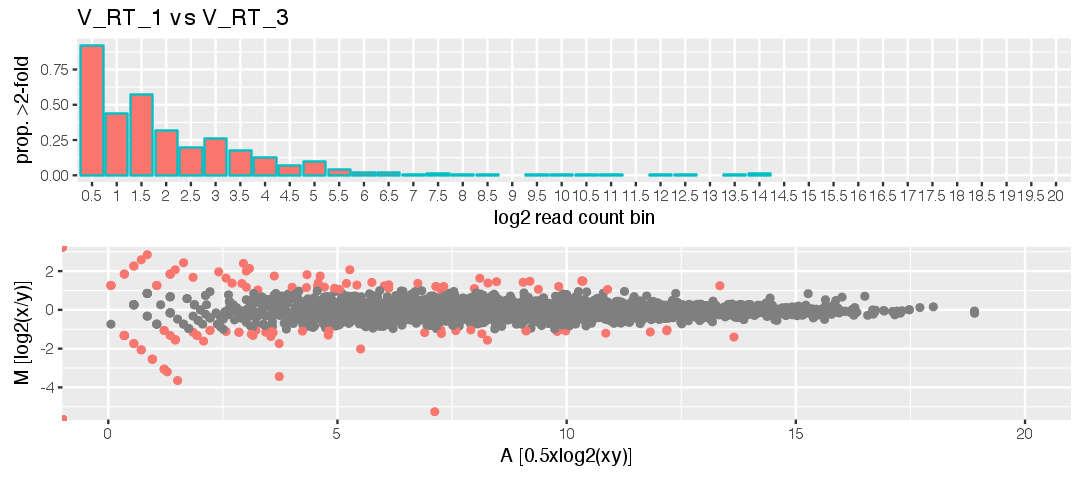

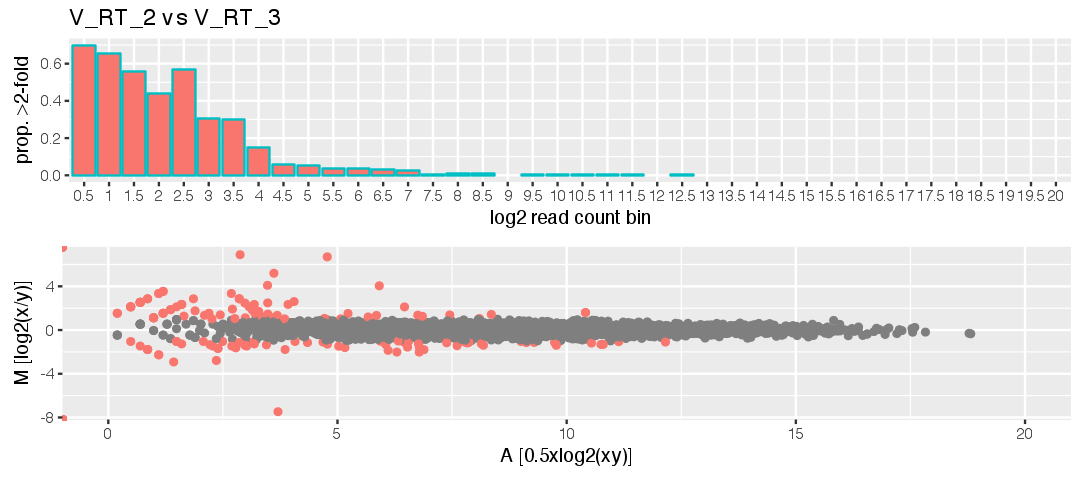

In [54]:
# normalize counts by the DESeq method (this is only used for these plots:
meta.v <- data.frame(row.names=colnames(countsMatrix.virgin.filt), condition=sampleInfo.v$Tissue)
countData.v<-round(countsMatrix.virgin.filt)
countData.v_normByDESeq = newCountDataSet(countData.v, meta.v)
countData.v_normByDESeq = estimateSizeFactors(countData.v_normByDESeq)
countData.v_normByDESeq = data.frame(counts(countData.v_normByDESeq, normalized=T))

options(repr.plot.width = 9, repr.plot.height = 4)
MA_BPlot(countData.v_normByDESeq, "V_CR_1", "V_CR_2")
MA_BPlot(countData.v_normByDESeq, "V_H_1", "V_H_2")
MA_BPlot(countData.v_normByDESeq, "V_OV_1", "V_OV_2")
MA_BPlot(countData.v_normByDESeq, "V_RT_1", "V_RT_2")
MA_BPlot(countData.v_normByDESeq, "V_RT_1", "V_RT_3")
MA_BPlot(countData.v_normByDESeq, "V_RT_2", "V_RT_3")

Now we can identify genes that show tissue-biased expression. First, we define the relevant contrasts. We'll need to define a set of three contrasts for each tissue:

In [66]:
cont.v.repTract <- makeContrasts(V_RT.vs.V_CR=repTract-carcass,
                                 V_RT.vs.V_HD=repTract-head,
                                 V_RT.vs.V_OV=repTract-ovaries,
                                 levels=design.v)
cont.v.ovaries <- makeContrasts(V_OV.vs.V_CR=ovaries-carcass,
                                V_OV.vs.V_HD=ovaries-head,
                                V_OV.vs.V_RT=ovaries-repTract,
                                levels=design.v)
cont.v.head <- makeContrasts(V_H.vs.V_CR=head-carcass,
                             V_H.vs.V_OV=head-ovaries,
                             V_H.vs.V_RT=head-repTract,
                             levels=design.v)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrasts, we will extract the table with the relevant DE stats.

###### Reproductive tract:

In [73]:
lrt.v.repTract <- glmLRT(dgeList.v_fit, contrast = cont.v.repTract)
lrt.v.repTract.tTags <- topTags(lrt.v.repTract, n = NULL)
lrt.v.repTract.tTags.table <- lrt.v.repTract.tTags$table
repTract.list<-rownames(subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_HD > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001))

In [71]:
length(rownames(dgeList.v_fit))

[1] 8501

In [58]:
repTract.list<-rownames(subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_H > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001))

In [63]:
contrasts.v.tissue

,V_RT.vs.V_CR,V_RT.vs.V_HD,V_RT.vs.V_OV,V_OV.vs.V_CR,V_OV.vs.V_HD,V_HD.vs.V_CR
carcass,-1,0,0,-1,0,-1
head,0,-1,0,0,-1,1
ovaries,0,0,-1,1,1,0
repTract,1,1,1,0,0,0


In [ ]:
virgin_RT_contrasts<- makeContrasts(V_RT.vs.V_CR=V_RT-V_CR, 
                                    V_RT.vs.V_H=V_RT-V_H,
                                    V_RT.vs.V_OV=V_RT-V_OV,
                                    levels=virgin.design)

virgin_OV_contrasts<- makeContrasts(V_OV.vs.V_CR=V_OV-V_CR, 
                                    V_OV.vs.V_H=V_OV-V_H,
                                    V_OV.vs.V_RT=V_OV-V_RT,
                                    levels=virgin.design)

virgin_H_contrasts<- makeContrasts(V_H.vs.V_CR=V_H-V_CR, 
                                   V_H.vs.V_OV=V_H-V_OV,
                                   V_H.vs.V_RT=V_H-V_RT,
                                   levels=virgin.design)

In [24]:
DnovPM_max_gene_expr_per_row = apply(DnovPM.dvir1.06.CountsMatrix, 1, max)
DnovPM.dvir1.06.CountsMatrix.min400count = DnovPM.dvir1.06.CountsMatrix[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

##########################################################################################
################# Remove "bad" replicates  for DE analysis ###############################
### Based on the QC analysis above, some replicates show inconsistencies that are likely due to cross tissue contamination
### during dissections. The DE analysis will exclude these replicates

## Define good replicates (propper replicate grouping and correlation)
DnovPM.GoodReps = as.character(subset(DnovPM.Samples_data, V2 != "H3_RT_1" & V2 != "H6_RT_1" & V2 != "C6_RT_1")$V2)
DnovPM.GoodSamples = subset(DnovPM.Samples_data, V2 != "H3_RT_1" & V2 != "H6_RT_1" & V2 != "C6_RT_1")

## Create counts matrix with good replicates only
DnovPM.dvir1.06.CountsMatrix.BRR=subset(DnovPM.dvir1.06.CountsMatrix, select=DnovPM.GoodReps)

## Create normalized TPM matrix with good replicates only
DnovPM.dvir1.06.TmmMatrix.BRR=subset(DnovPM.dvir1.06.TmmMatrix, select=DnovPM.GoodReps)

## Rename columns to keep replicate order
# count matrices
colnames(DnovPM.dvir1.06.CountsMatrix.BRR) = DnovPM.GoodReps

# TPM matrices
colnames(DnovPM.dvir1.06.TmmMatrix.BRR) = colnames(DnovPM.dvir1.06.CountsMatrix.BRR)


#########################################################################################
### Summary TPM table and matrix for gene level plots (includes good replicates only) ######### 

DnovPM.TPM.tmp<-DnovPM.dvir1.06.TmmMatrix.BRR
colnames(DnovPM.TPM.tmp) <- DnovPM.GoodSamples$V1
m.DnovPM.TPM.tmp <- as.data.frame(melt(as.matrix(DnovPM.TPM.tmp)))
m.DnovPM.TPM.tmp <- within(m.DnovPM.TPM.tmp, X2<-data.frame(do.call('rbind', strsplit(as.character(X2),'_',fixed=TRUE))))
m.DnovPM.TPM.tmp<-data.frame(m.DnovPM.TPM.tmp$X1, m.DnovPM.TPM.tmp$X2$X1, m.DnovPM.TPM.tmp$X2$X2, m.DnovPM.TPM.tmp$value)
colnames(m.DnovPM.TPM.tmp) <- c("FBgn_ID", "sample", "tissue", "TPM")
m.DnovPM.TPM.tmp$condition <- ifelse(grepl("C", m.DnovPM.TPM.tmp$sample, ignore.case = F), "conspecific", ifelse(grepl("H", m.DnovPM.TPM.tmp$sample, ignore.case = F), "heterospecific", "virgin"))
m.DnovPM.TPM.tmp$time <- ifelse(grepl("3", m.DnovPM.TPM.tmp$sample), "3hpm", ifelse(grepl("6", m.DnovPM.TPM.tmp$sample), "6hpm", ifelse(grepl("12", m.DnovPM.TPM.tmp$sample), "12hpm","virgin")))
m.DnovPM.TPM.tmp.c = summarySE(m.DnovPM.TPM.tmp, measurevar = "TPM", groupvars = c("FBgn_ID", "sample", "tissue", "condition", "time"))
fbgn_to_geneName<-subset(gffRecord, select=c(FBgn_ID, gene_name))
TPMse_DnovPM <- merge(fbgn_to_geneName, m.DnovPM.TPM.tmp.c, all=TRUE)
DnovPM_MeanTPMmatrix<-cast(m.DnovPM.TPM.tmp.c, FBgn_ID~sample+tissue, value ="TPM")
TPMse_DnovPM$condition = factor (TPMse_DnovPM$condition, levels = c("virgin", "conspecific", "heterospecific"))
TPMse_DnovPM$time = factor (TPMse_DnovPM$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))

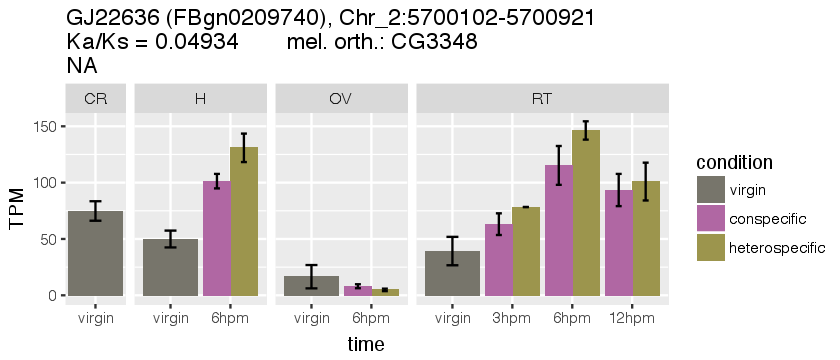

In [25]:
## plot a gene's expression like this:
options(repr.plot.width = 7, repr.plot.height = 3)

plotGenePM(TPMse_DnovPM, "GJ22636")

In [26]:
subset(paml.data, gene_name == "GJ19434")

,FBgn_ID,gene_name,chromosome,min,max,orientation,FBtr_ID,omega,H0_lnL,Damr_brSt_H0,Damr_brSt_H1,Dlum_brSt_H0,Dlum_brSt_H1,Dnov_brSt_H0,Dnov_brSt_H1,Dvir_brSt_H0,Dvir_brSt_H1,DamrNov_brSt_H0,DamrNov_brSt_H1
12438,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0442802,0.12873,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-374.0663,-373.5153,-373.5153,-374.0663,-374.0663
12439,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0439591,1.52539,-631.7494,-632.0389,-631.8861,-632.0389,-632.0389,-632.0389,-629.2079,-632.0389,-630.7387,-630.8898,-630.8898
12440,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0442700,0.30853,-741.5798,-740.5816,-740.5257,-740.4267,-740.4267,-740.5898,-740.5898,-740.5898,-740.5898,-740.5898,-740.5898
12441,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0235359,0.12332,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.6655,-373.1153,-373.1153,-373.6655,-373.6655
12442,FBgn0206577,GJ19434,Chr_X,21472903,21479376,-,FBtr0435206,1.52539,-631.7494,-632.0389,-631.8861,-632.0389,-632.0389,-632.0389,-629.2079,-632.0389,-630.7387,-630.8898,-630.8898


#### Tissue Specificity

The tissue specificty index (_S_) can be calculated for each gene using the virgin tissue samples.

In [27]:
### this is incomplete
Dnov_virgin_tissue_MeanTPMmatrix <- subset(DnovPM_MeanTPMmatrix, select=c(FBgn_ID, V_CR, V_H, V_OV, V_RT))
rownames(Dnov_virgin_tissue_MeanTPMmatrix) <- Dnov_virgin_tissue_MeanTPMmatrix[,1]
Dnov_virgin_tissue_MeanTPMmatrix[,1] <- NULL

## Differential expression analysis

In [31]:
virgin_RT_contrasts<- makeContrasts(V_RT.vs.V_CR=V_RT-V_CR, 
                                        V_RT.vs.V_H=V_RT-V_H,
                                        V_RT.vs.V_OV=V_RT-V_OV,
                                        levels=DnovPM.design)

virgin_OV_contrasts<- makeContrasts(V_OV.vs.V_CR=V_OV-V_CR, 
                                    V_OV.vs.V_H=V_OV-V_H,
                                    V_OV.vs.V_RT=V_OV-V_RT,
                                    levels=DnovPM.design)

virgin_H_contrasts<- makeContrasts(V_H.vs.V_CR=V_H-V_CR, 
                                    V_H.vs.V_OV=V_H-V_OV,
                                    V_H.vs.V_RT=V_H-V_RT,
                                    levels=DnovPM.design)

For each tissue, extract genes that show >2-fold abundance and FDR<0.001:

In [32]:
## RT-biased genes
lrt.RT.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_RT_contrasts)
lrt.RT.v.rest.tTags <- topTags(lrt.RT.v.rest, n = NULL)
lrt.RT.v.rest.tTags.table <- lrt.RT.v.rest.tTags$table
Dnov.dvir1.06.RT.list<-rownames(subset(lrt.RT.v.rest.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_H > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001))

## OV-biased genes
lrt.OV.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_OV_contrasts)
lrt.OV.v.rest.tTags <- topTags(lrt.OV.v.rest, n = NULL)
lrt.OV.v.rest.tTags.table <- lrt.OV.v.rest.tTags$table
Dnov.dvir1.06.OV.list<-rownames(subset(lrt.OV.v.rest.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_H > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.001))

## H-biased genes
lrt.H.v.rest <- glmLRT(DnovPM_fit, contrast = virgin_H_contrasts)
lrt.H.v.rest.tTags <- topTags(lrt.H.v.rest, n = NULL)
lrt.H.v.rest.tTags.table <- lrt.H.v.rest.tTags$table
Dnov.dvir1.06.H.list<-rownames(subset(lrt.H.v.rest.tTags.table, logFC.V_H.vs.V_CR > 2 & logFC.V_H.vs.V_OV > 2 & logFC.V_H.vs.V_RT > 2 & FDR<0.001))

We can plot a heatmap of any list of genes by first extracting mean expression values from the matrix of mean TPM values, for example, for RT-biased genes:

In [33]:
Dnov.dvir1.06.RT.matrix <- subset(Dnov_virgin_tissue_MeanTPMmatrix, rownames(Dnov_virgin_tissue_MeanTPMmatrix) %in% Dnov.dvir1.06.RT.list)

In [34]:
length(Dnov.dvir1.06.RT.list) 

[1] 261

Then plot those using the `plotHeatmap` functions:

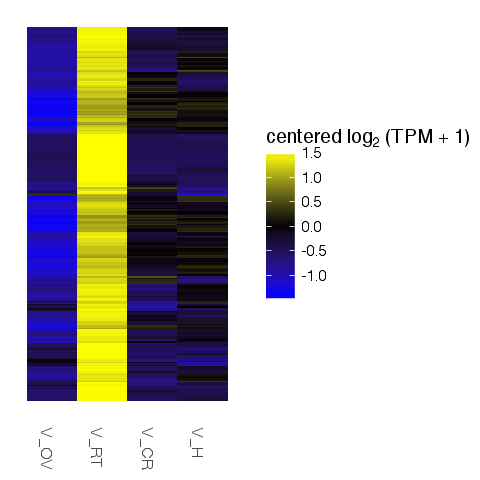

In [35]:
options(repr.plot.width = 4, repr.plot.height = 4)
plotHeatmap(Dnov.dvir1.06.RT.matrix, clustering = "both", labRow = F)

Here's a plot of RT-biased genes along chromosomes and their Ka/Ks values

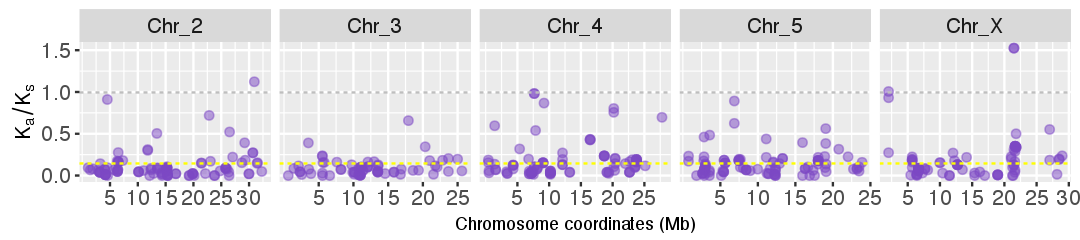

In [36]:
options(repr.plot.width = 9, repr.plot.height = 2)
ggplot(subset(paml.data, FBgn_ID %in% Dnov.dvir1.06.RT.list & omega < 800 & grepl("Chr", chromosome)), aes(max, omega)) + 
    geom_point(size=2, alpha=0.5, colour = "#7d49c3") + 
  #  geom_point(data=subset(paml.data, FBgn_ID %in% SFP_elements$`D.ame,D.lum,D.nov,D.vir` ), aes(max, omega), inherit.aes = F, size=2, alpha=0.5, colour = "#4f922a") + 
    geom_hline(yintercept = 0.15, linetype="dashed", colour = "yellow") + 
    geom_hline(yintercept = 1, linetype="dashed", colour = "gray")  + 
    facet_grid(~chromosome, scales = "free_x") + 
#    scale_colour_manual(name = "", values =c("#7aa457"="#7aa457","#9e6ebd"="#9e6ebd"), labels = c("SFPs","EB biased")) + 
    scale_x_continuous(breaks=seq(5000000,30000000,5000000), labels=expression("5", "10", "15", "20", "25", "30")) + 
    xlab ("Chromosome coordinates (Mb)") + 
    labs(y=expression(K[a]/K[s])) + 
#    geom_text_repel(data=subset(paml.data, FBgn_ID %in% Dnov.dvir1.06.RT.list & omega > 0.95 & omega < 800), aes(label = gene_name), size =3, force = 30, colour = "#7d49c3") +
  #  geom_text_repel(data=subset(paml.data, gene_name == "GJ21515"), aes(label = gene_name), size =3, force = 30, colour = "#4f922a") +
  #  geom_text_repel(data=subset(paml.data, FBgn_ID %in% SFP_elements$`D.ame,D.lum,D.nov,D.vir` & omega > 0.8), aes(label = gene_name), size =3, force = 4, colour = "#4f922a") +
    theme(axis.title.x = element_text(face = "bold", size = 10, vjust=0.1), axis.text.x=element_text(face = "bold", size = 12),axis.text.y = element_text(face = "bold", size = 12), axis.title.y = element_text(face = "bold.italic", size = 12, vjust=0.1), strip.text=element_text(face="bold", size = 12))



## Gene Ontology analysis

Need gene length information and GO annotation files

In [37]:
gene_lengths = read.table("GO.analysis/FBgn_lengths.txt", header=T, row.names=1)
gene_lengths = as.matrix(gene_lengths[,1,drop=F])
GO_info = read.table("GO.analysis/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

Define gene groups

In [38]:
RT_factors = as.data.frame(Dnov.dvir1.06.RT.list)
RT_factors$V1 = "RT-biased"
rownames(RT_factors) = Dnov.dvir1.06.RT.list
RT_factors = subset(RT_factors, select = "V1")

OV_factors = as.data.frame(Dnov.dvir1.06.OV.list)
OV_factors$V1 = "OV-biased"
rownames(OV_factors) = Dnov.dvir1.06.OV.list
OV_factors = subset(OV_factors, select = "V1")

H_factors = as.data.frame(Dnov.dvir1.06.H.list)
H_factors$V1 = "H-biased"
rownames(H_factors) = Dnov.dvir1.06.H.list
H_factors = subset(H_factors, select = "V1")

factor_labeling = rbind(RT_factors, OV_factors, H_factors)
colnames(factor_labeling) = c('type')
factor_list = unique(factor_labeling[,1])

Warning message in pcls(G):
"initial point very close to some inequality constraints"

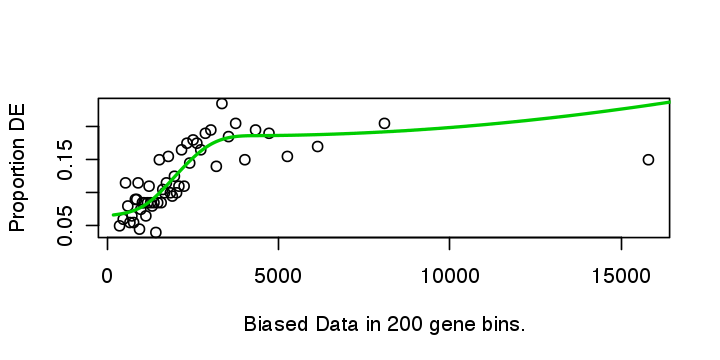

In [39]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(factor_labeling))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

In [40]:
GO_enriched_list = list()

for (feature_cat in factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(factor_labeling)[factor_labeling$type == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: RT-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: OV-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: H-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


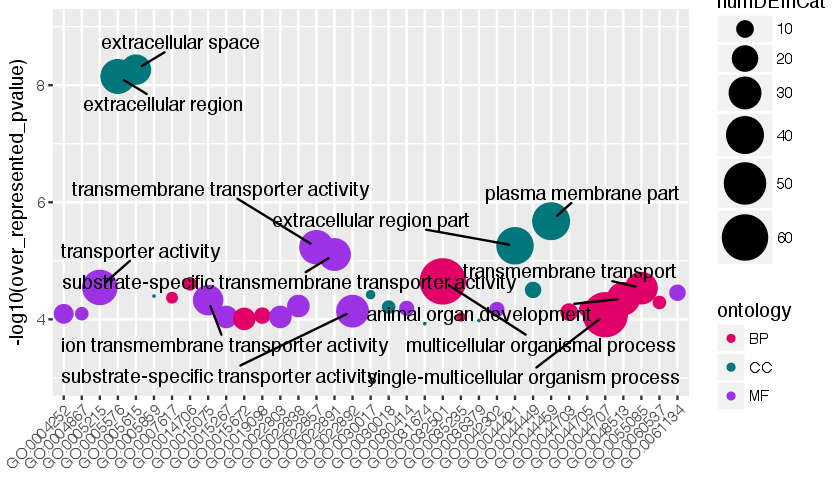

In [41]:
### RT plot
options(repr.plot.width = 7, repr.plot.height = 4)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "RT-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point()  + 
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, factor == "RT-biased" & over_represented_FDR < 0.05 & numDEInCat > 20), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 8, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) + 
    scale_y_continuous(limits=c(3, 9))

#### Reproductive tract post-mating contrasts:

Create RT-specific count matrix 

In [42]:
DnovPM_CountsMatrix_RT = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("RT", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))

Filter this matrix by minimum read count:

In [43]:
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_RT, 1, max)
DnovPM_CountsMatrix_RT.min400 = DnovPM_CountsMatrix_RT[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

In [44]:
head(DnovPM_CountsMatrix_RT.min400)

,C12_RT_1,C12_RT_2,C12_RT_3,C3_RT_1,C3_RT_2,C3_RT_3,C6_RT_2,C6_RT_3,H12_RT_1,H12_RT_2,H12_RT_3,H3_RT_2,H3_RT_3,H6_RT_2,H6_RT_3,V_RT_1,V_RT_2,V_RT_3
FBgn0202928,435.52,541.22,553.43,380.65,534.23,466.21,731.63,433.42,854.99,943.25,691.22,467.27,994.93,1023.68,646.37,1092.88,863.67,1396.54
FBgn0199563,298.09,479.05,462.67,318.37,358.64,348.37,536.98,392.55,701.70,792.18,576.08,439.20,761.34,906.30,451.57,631.27,559.54,715.31
FBgn0206588,945.11,1517.41,1416.42,1005.06,1266.19,1489.42,1620.62,1347.77,2444.35,2675.51,1962.39,1798.57,3041.42,3692.64,1336.11,1992.25,1559.37,2273.14
FBgn0209112,4210.54,6065.79,6846.71,5825.36,6491.43,6060.99,7472.51,5589.99,11335.59,13959.97,9401.40,7315.25,14172.82,15716.41,8518.75,13062.22,12407.59,18214.81
FBgn0199619,17366.10,28560.49,27162.75,17488.97,19332.37,20146.09,30799.76,22289.46,44247.30,45797.95,33756.23,23929.07,43550.17,53683.53,27844.57,36968.67,32613.69,49394.90
FBgn0204214,5648.44,9174.87,7668.11,6162.42,7809.01,5854.85,8596.33,7860.91,12156.30,12852.00,10063.44,5469.68,12391.59,13329.43,7001.61,18221.55,19460.64,25679.84


Generate design matrix and define groups

In [45]:
RT.group <- factor(c(1,1,1,2,2,2,3,3,4,4,4,5,5,6,6,7,7,7))
RT.design <- model.matrix(~0+RT.group)
colnames(RT.design)<-c("C12_RT", "C3_RT", "C6_RT", "H12_RT", "H3_RT", "H6_RT", "V_RT")

Create edgeR DE object and run glmFit

In [46]:
DnovPM_DGElist_RT<-DGEList(counts = DnovPM_CountsMatrix_RT.min400, group = RT.group)
DnovPM_DGElist_RT<-calcNormFactors(DnovPM_DGElist_RT)
DnovPM_DGElist_RT<-estimateDisp(DnovPM_DGElist_RT, RT.design, robust = T)
DnovPM_RT_fit <- glmFit(DnovPM_DGElist_RT, RT.design)

In [61]:
g <- gof(DnovPM_RT_fit)
z <- zscoreGamma(g$gof.statistics,shape=gof$df / 2,scale=2)

ERROR: Error in gof$df: object of type 'closure' is not subsettable


Define contrasts to be tested

In [47]:
con_virgin_contrasts <- makeContrasts(C3.vs.V=C3_RT-V_RT, C6.vs.V=C6_RT-V_RT, C12.vs.V=C12_RT-V_RT, levels = RT.design)
het_virgin_contrasts <- makeContrasts(H3.vs.V=H3_RT-V_RT, H6.vs.V=H6_RT-V_RT, H12.vs.V=H12_RT-V_RT, levels = RT.design)

Identify DE genes between virgin and all postmating samples

In [48]:
RT_con.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts)
RT_con.vs.virgin.tTags <- topTags(RT_con.vs.virgin, n = NULL)
RT_con.vs.virgin.tTags.table <- RT_con.vs.virgin.tTags$table
RT_con.vs.virgin.tTags.table$FBgn_ID <- rownames(RT_con.vs.virgin.tTags.table)

RT_het.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts)
RT_het.vs.virgin.tTags <- topTags(RT_het.vs.virgin, n = NULL)
RT_het.vs.virgin.tTags.table <- RT_het.vs.virgin.tTags$table
RT_het.vs.virgin.tTags.table$FBgn_ID <- rownames(RT_het.vs.virgin.tTags.table)

In [49]:
colnames(RT_con.vs.virgin.tTags.table) = c("3hpm", "6hpm", "12hpm", "logCPM", "LR", "pvalue", "FDR", "FBgn_ID")
colnames(RT_het.vs.virgin.tTags.table) = c("3hpm", "6hpm", "12hpm", "logCPM", "LR", "pvalue", "FDR", "FBgn_ID")

head(RT_con.vs.virgin.tTags.table)
head(RT_het.vs.virgin.tTags.table)

,3hpm,6hpm,12hpm,logCPM,LR,pvalue,FDR,FBgn_ID
FBgn0198861,2.9935293,1.204777,0.3051668,5.241462,873.2722,5.550898e-189,3.710220e-185,FBgn0198861
FBgn0199412,2.0701762,3.504898,4.0818578,7.766424,659.5361,1.246726e-142,4.166558e-139,FBgn0199412
FBgn0198037,-1.8604222,-2.203550,-2.8935859,3.309744,337.8169,6.479754e-73,1.443689e-69,FBgn0198037
FBgn0208092,2.3176135,3.063180,2.0314281,6.720275,294.3007,1.703014e-63,2.845737e-60,FBgn0208092
FBgn0209375,0.7611869,2.202677,2.0905668,5.235392,259.1301,6.933999e-56,9.269370e-53,FBgn0209375
FBgn0200611,1.3625801,2.026408,1.7716102,7.202215,249.1764,9.861973e-54,1.082821e-50,FBgn0200611


,3hpm,6hpm,12hpm,logCPM,LR,pvalue,FDR,FBgn_ID
FBgn0208031,7.012423,6.535943,-0.05205981,2.418138,1327.2971,1.757327e-287,1.174598e-283,FBgn0208031
FBgn0198861,2.775086,1.454250,0.38921066,5.241462,618.8314,8.334880e-134,2.785517e-130,FBgn0198861
FBgn0199412,2.325487,3.403601,3.92392518,7.766424,573.8805,4.629583e-124,1.031471e-120,FBgn0199412
FBgn0206847,3.346474,2.729407,0.61313307,2.935890,519.9622,2.251187e-112,3.761733e-109,FBgn0206847
FBgn0203480,1.638590,1.093669,0.03535923,5.121406,382.8619,1.140744e-82,1.524947e-79,FBgn0203480
FBgn0205175,2.641661,2.162041,0.85732450,4.989258,316.6537,2.472435e-68,2.754292e-65,FBgn0205175


In [50]:
PM.RT.con_vs_virgin.m <-melt(RT_con.vs.virgin.tTags.table, id.vars = c("pvalue", "FDR", "FBgn_ID", "LR", "logCPM"))
PM.RT.con_vs_virgin.m$cross = "Conspecific"
PM.RT.het_vs_virgin.m <-melt(RT_het.vs.virgin.tTags.table, id.vars = c("pvalue", "FDR", "FBgn_ID", "LR", "logCPM"))
PM.RT.het_vs_virgin.m$cross = "Heterospecific"

RT.PM_vs_virgin.m = rbind(PM.RT.con_vs_virgin.m, PM.RT.het_vs_virgin.m)
RT.PM_vs_virgin.m$sig = ifelse(RT.PM_vs_virgin.m$FDR < 0.00001, "YES", "NO")
head(RT.PM_vs_virgin.m)

pvalue,FDR,FBgn_ID,LR,logCPM,variable,value,cross,sig
5.550898e-189,3.710220e-185,FBgn0198861,873.2722,5.241462,3hpm,2.9935293,Conspecific,YES
1.246726e-142,4.166558e-139,FBgn0199412,659.5361,7.766424,3hpm,2.0701762,Conspecific,YES
6.479754e-73,1.443689e-69,FBgn0198037,337.8169,3.309744,3hpm,-1.8604222,Conspecific,YES
1.703014e-63,2.845737e-60,FBgn0208092,294.3007,6.720275,3hpm,2.3176135,Conspecific,YES
6.933999e-56,9.269370e-53,FBgn0209375,259.1301,5.235392,3hpm,0.7611869,Conspecific,YES
9.861973e-54,1.082821e-50,FBgn0200611,249.1764,7.202215,3hpm,1.3625801,Conspecific,YES


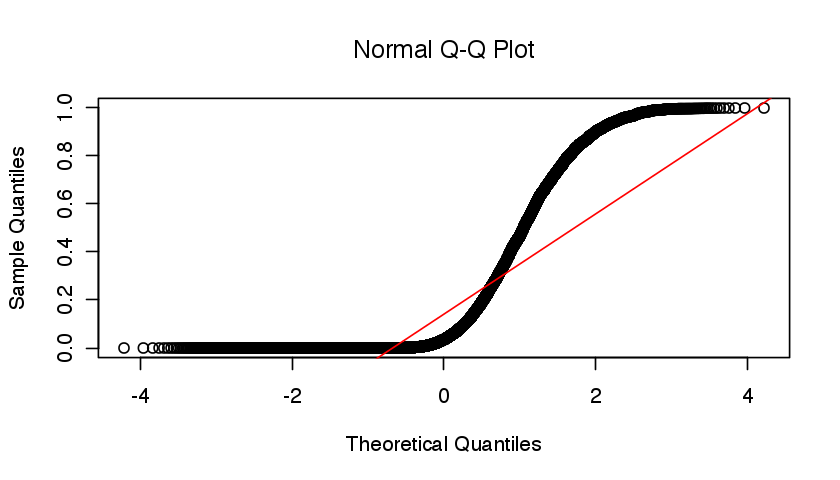

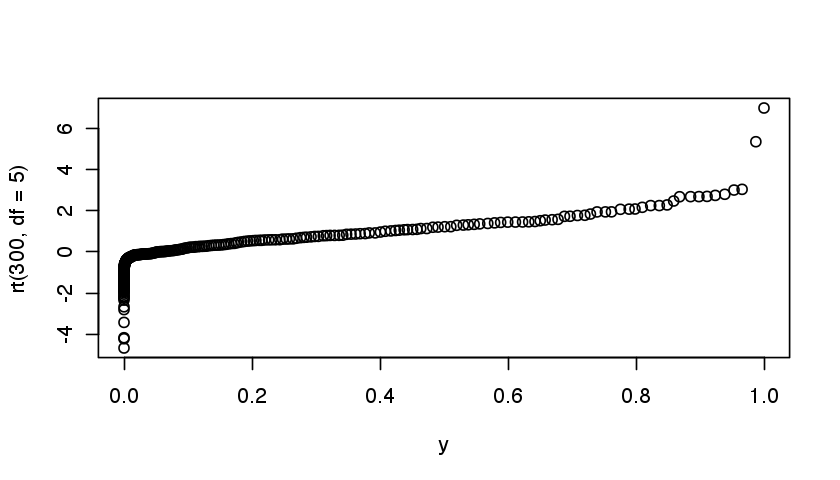

In [55]:
y <- RT.PM_vs_virgin.m$pvalue
qqnorm(y); qqline(y, col = 2)
qqplot(y, rt(300, df = 5))

In [52]:
ggplot(data, aes(sample = RT.PM_vs_virgin.m$pvalue)) + stat_qq(color="firebrick2", alpha=1) + geom_abline(intercept = mean(RT.PM_vs_virgin.m$pvalue), slope = sd(RT.PM_vs_virgin.m$pvalue))

ERROR: Error: ggplot2 doesn't know how to deal with data of class matrix


In [ ]:
options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(RT.PM_vs_virgin.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_grid(cross~variable, scales = "free")

In [ ]:
length(unique(subset(RT.PM_vs_virgin.m, sig == "YES")$FBgn_ID))

### Pair-wise DE contrasts

Perform pair-wise DE analysis between each PM RT sample and the virgin RT sample

In [ ]:
# C3_RT vs V_RT
RT_con.3hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C3.vs.V"])
RT_con.3hrs.vs.virgin.tTags <- topTags(RT_con.3hrs.vs.virgin, n = NULL)
RT_con.3hrs.vs.virgin.tTags.table <- RT_con.3hrs.vs.virgin.tTags$table
RT_con.3hrs.vs.virgin.Up.list <- rownames(subset(RT_con.3hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.3hrs.vs.virgin.Down.list <- rownames(subset(RT_con.3hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# C6_RT vs V_RT
RT_con.6hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C6.vs.V"])
RT_con.6hrs.vs.virgin.tTags <- topTags(RT_con.6hrs.vs.virgin, n = NULL)
RT_con.6hrs.vs.virgin.tTags.table <- RT_con.6hrs.vs.virgin.tTags$table
RT_con.6hrs.vs.virgin.Up.list <- rownames(subset(RT_con.6hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.6hrs.vs.virgin.Down.list <- rownames(subset(RT_con.6hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# C12_RT vs V_RT
RT_con.12hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C12.vs.V"])
RT_con.12hrs.vs.virgin.tTags <- topTags(RT_con.12hrs.vs.virgin, n = NULL)
RT_con.12hrs.vs.virgin.tTags.table <- RT_con.12hrs.vs.virgin.tTags$table
RT_con.12hrs.vs.virgin.Up.list <- rownames(subset(RT_con.12hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.12hrs.vs.virgin.Down.list <- rownames(subset(RT_con.12hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
# H3_RT vs V_RT
RT_het.3hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H3.vs.V"])
RT_het.3hrs.vs.virgin.tTags <- topTags(RT_het.3hrs.vs.virgin, n = NULL)
RT_het.3hrs.vs.virgin.tTags.table <- RT_het.3hrs.vs.virgin.tTags$table
RT_het.3hrs.vs.virgin.Up.list <- rownames(subset(RT_het.3hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.3hrs.vs.virgin.Down.list <- rownames(subset(RT_het.3hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# H6_RT vs V_RT
RT_het.6hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H6.vs.V"])
RT_het.6hrs.vs.virgin.tTags <- topTags(RT_het.6hrs.vs.virgin, n = NULL)
RT_het.6hrs.vs.virgin.tTags.table <- RT_het.6hrs.vs.virgin.tTags$table
RT_het.6hrs.vs.virgin.Up.list <- rownames(subset(RT_het.6hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.6hrs.vs.virgin.Down.list <- rownames(subset(RT_het.6hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# H12_RT vs V_RT
RT_het.12hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H12.vs.V"])
RT_het.12hrs.vs.virgin.tTags <- topTags(RT_het.12hrs.vs.virgin, n = NULL)
RT_het.12hrs.vs.virgin.tTags.table <- RT_het.12hrs.vs.virgin.tTags$table
RT_het.12hrs.vs.virgin.Up.list <- rownames(subset(RT_het.12hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.12hrs.vs.virgin.Down.list <- rownames(subset(RT_het.12hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
RT_UP_3hrs_candidates <- list(Conspecific = RT_con.3hrs.vs.virgin.Up.list, Heterospecific = RT_het.3hrs.vs.virgin.Up.list)
RT_UP_6hrs_candidates <- list(Conspecific = RT_con.6hrs.vs.virgin.Up.list, Heterospecific = RT_het.6hrs.vs.virgin.Up.list)
RT_UP_12hrs_candidates <- list(Conspecific = RT_con.12hrs.vs.virgin.Up.list, Heterospecific = RT_het.12hrs.vs.virgin.Up.list)
RT_Down_3hrs_candidates <- list(Conspecific = RT_con.3hrs.vs.virgin.Down.list, Heterospecific = RT_het.3hrs.vs.virgin.Down.list)
RT_Down_6hrs_candidates <- list(Conspecific = RT_con.6hrs.vs.virgin.Down.list, Heterospecific = RT_het.6hrs.vs.virgin.Down.list)
RT_Down_12hrs_candidates <- list(Conspecific = RT_con.12hrs.vs.virgin.Down.list, Heterospecific = RT_het.12hrs.vs.virgin.Down.list)

In [ ]:
# Rearrange into lists of lists, and partition by species
RT_UP_3hrs_combs <- unlist(lapply(1:length(RT_UP_3hrs_candidates), function(j) combn(names(RT_UP_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_6hrs_combs <- unlist(lapply(1:length(RT_UP_6hrs_candidates), function(j) combn(names(RT_UP_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_12hrs_combs <- unlist(lapply(1:length(RT_UP_12hrs_candidates), function(j) combn(names(RT_UP_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_3hrs_combs <- unlist(lapply(1:length(RT_Down_3hrs_candidates), function(j) combn(names(RT_Down_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_6hrs_combs <- unlist(lapply(1:length(RT_Down_6hrs_candidates), function(j) combn(names(RT_Down_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_12hrs_combs <- unlist(lapply(1:length(RT_Down_12hrs_candidates), function(j) combn(names(RT_Down_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)

names(RT_UP_3hrs_combs) <- sapply(RT_UP_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_6hrs_combs) <- sapply(RT_UP_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_12hrs_combs) <- sapply(RT_UP_12hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_3hrs_combs) <- sapply(RT_Down_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_6hrs_combs) <- sapply(RT_Down_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_12hrs_combs) <- sapply(RT_Down_12hrs_combs, function(i) paste0(i, collapse = ","))

RT_UP_3hrs_elements <- lapply(RT_UP_3hrs_combs, function(i) Setdiff(RT_UP_3hrs_candidates[i], RT_UP_3hrs_candidates[setdiff(names(RT_UP_3hrs_candidates), i)]))
RT_UP_6hrs_elements <- lapply(RT_UP_6hrs_combs, function(i) Setdiff(RT_UP_6hrs_candidates[i], RT_UP_6hrs_candidates[setdiff(names(RT_UP_6hrs_candidates), i)]))
RT_UP_12hrs_elements <- lapply(RT_UP_12hrs_combs, function(i) Setdiff(RT_UP_12hrs_candidates[i], RT_UP_12hrs_candidates[setdiff(names(RT_UP_12hrs_candidates), i)]))
RT_Down_3hrs_elements <- lapply(RT_Down_3hrs_combs, function(i) Setdiff(RT_Down_3hrs_candidates[i], RT_Down_3hrs_candidates[setdiff(names(RT_Down_3hrs_candidates), i)]))
RT_Down_6hrs_elements <- lapply(RT_Down_6hrs_combs, function(i) Setdiff(RT_Down_6hrs_candidates[i], RT_Down_6hrs_candidates[setdiff(names(RT_Down_6hrs_candidates), i)]))
RT_Down_12hrs_elements <- lapply(RT_Down_12hrs_combs, function(i) Setdiff(RT_Down_12hrs_candidates[i], RT_Down_12hrs_candidates[setdiff(names(RT_Down_12hrs_candidates), i)]))

In [ ]:
### Draw a VennDiagram of each element
RT_UP_3hrs_Vdiag<-venn.diagram(RT_UP_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_UP_6hrs_Vdiag<-venn.diagram(RT_UP_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_UP_12hrs_Vdiag<-venn.diagram(RT_UP_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")

options(repr.plot.width = 4, repr.plot.height = 3)
grid.arrange(gTree(children=RT_UP_3hrs_Vdiag), gTree(children=RT_UP_6hrs_Vdiag), gTree(children=RT_UP_12hrs_Vdiag))

In [ ]:
RT_Down_3hrs_Vdiag<-venn.diagram(RT_Down_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_Down_6hrs_Vdiag<-venn.diagram(RT_Down_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_Down_12hrs_Vdiag<-venn.diagram(RT_Down_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")

options(repr.plot.width = 4, repr.plot.height = 3)
grid.arrange(gTree(children=RT_Down_3hrs_Vdiag), gTree(children=RT_Down_6hrs_Vdiag), gTree(children=RT_Down_12hrs_Vdiag))

Test Difference between conspecific and heterospecific PM samples:

In [ ]:
condition.group = subset(m.DnovPM.TPM.tmp, FBgn_ID == "FBgn0202928" & tissue == "RT")
condition.group$replicates = colnames(DnovPM_CountsMatrix_RT.min400)
rownames(condition.group) <- condition.group$replicates
condition.group = subset(condition.group, select = c(sample, condition, time))

condition.design <- model.matrix(~0+condition, data = condition.group)
colnames(condition.design) <- unique(condition.group$condition)

condition.contrasts <- makeContrasts(con.vs.het = conspecific-heterospecific,
                                     con.vs.vir = conspecific - virgin,
                                     het.vs.vir = heterospecific - virgin,
                                     levels = condition.design)

In [ ]:
lrt <- glmFit(DnovPM_DGElist_RT, condition.design)
con.vs.het.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"con.vs.het"])
con.vs.het.RT.all.tTags <- topTags(con.vs.het.RT.all.contrast, n = NULL)
con.vs.het.RT.all.tTags.table <- con.vs.het.RT.all.tTags$table
con.vs.het.RT.het.Up.list <- rownames(subset(con.vs.het.RT.all.tTags.table, logFC < -1 & FDR < 0.001))
con.vs.het.RT.con.Up.list <- rownames(subset(con.vs.het.RT.all.tTags.table, logFC > 1 & FDR < 0.001))

con.vs.vir.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"con.vs.vir"])
con.vs.vir.RT.all.tTags <- topTags(con.vs.vir.RT.all.contrast, n = NULL)
con.vs.vir.RT.all.tTags.table <- con.vs.vir.RT.all.tTags$table
con.vs.vir.RT.con.Up.list <- rownames(subset(con.vs.vir.RT.all.tTags.table, logFC > 1 & FDR < 0.001))
con.vs.vir.RT.con.Down.list <- rownames(subset(con.vs.vir.RT.all.tTags.table, logFC < -1 & FDR < 0.001))

het.vs.vir.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"het.vs.vir"])
het.vs.vir.RT.all.tTags <- topTags(het.vs.vir.RT.all.contrast, n = NULL)
het.vs.vir.RT.all.tTags.table <- het.vs.vir.RT.all.tTags$table
het.vs.vir.RT.het.Up.list <- rownames(subset(het.vs.vir.RT.all.tTags.table, logFC > 1 & FDR < 0.001))
het.vs.vir.RT.het.Down.list <- rownames(subset(het.vs.vir.RT.all.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
PM.vs.vir_Up_candidates <- list(conspecific = con.vs.vir.RT.con.Up.list, heterospecific = het.vs.vir.RT.het.Up.list)
PM.vs.vir_Down_candidates <- list(conspecific = con.vs.vir.RT.con.Down.list, heterospecific = het.vs.vir.RT.het.Down.list)


PM.vs.vir_Up_candidates_Vdiag<-venn.diagram(PM.vs.vir_Up_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 4, cat.cex = 0, resolution = 1000, main = "Upregulated")
PM.vs.vir_Down_candidates_Vdiag<-venn.diagram(PM.vs.vir_Down_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 4, cat.cex = 0, resolution = 1000, main = "Downregulated")
options(repr.plot.width = 4, repr.plot.height = 1)
grid.arrange(gTree(children=PM.vs.vir_Up_candidates_Vdiag))
grid.arrange(gTree(children=PM.vs.vir_Down_candidates_Vdiag))


In [ ]:
RT_UP_3hrs_candidates

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
lapply(RT_UP_6hrs_candidates$Heterospecific, plotGenePM, object = TPMse_DnovPM)

### Ovary contrasts

In [ ]:
########### RT contrasts
# create RT-specific count matrix and define groups/design
DnovPM_CountsMatrix_OV = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("OV", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))

## filter this matrix by minimum read count
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_OV, 1, max)
DnovPM_CountsMatrix_OV.min200 = DnovPM_CountsMatrix_OV[DnovPM_max_gene_expr_per_row >= 200,,drop=F ]
head(DnovPM_CountsMatrix_OV.min200)

In [ ]:
######
OV.group <- factor(c(1,1,2,2,3,3))
OV.design <- model.matrix(~0+OV.group)
colnames(OV.design)<-c("C6_OV", "H6_OV", "V_OV")
OV.group
OV.design

In [ ]:
# create edgeR DE object and run glm
DnovPM_DGElist_OV<-DGEList(counts = DnovPM_CountsMatrix_OV.min200, group = OV.group)
DnovPM_DGElist_OV<-calcNormFactors(DnovPM_DGElist_OV)
DnovPM_DGElist_OV<-estimateDisp(DnovPM_DGElist_OV, OV.design, robust = T)
DnovPM_OV_fit <- glmFit(DnovPM_DGElist_OV, OV.design)

# define contrasts
OV_contrasts <- makeContrasts(C6.vs.V=C6_OV-V_OV, H6.vs.V=H6_OV-V_OV, C6.vs.H6=C6_OV-H6_OV, levels = OV.design)
OV_contrasts

In [ ]:
# identify overall con_vs_het
OV_all_comaprisons <- glmLRT(DnovPM_OV_fit, contrast = OV_contrasts)
OV_all_comaprisons.tTags <- topTags(OV_all_comaprisons, n = NULL)
OV_all_comaprisons.tTags.table <- OV_all_comaprisons.tTags$table
OV_all_comaprisons.tTags.table$FBgn_ID <- rownames(OV_all_comaprisons.tTags.table)
head(OV_all_comaprisons.tTags.table)

In [ ]:
colnames(OV_all_comaprisons.tTags.table) = c("conspceific", "heterospecific", "logCPM", "LR", "p-value", "FDR", "FBgn_ID")
OV_all_comaprisons.tTags.table.m <-melt(OV_all_comaprisons.tTags.table, id.vars = c("p-value", "FDR", "FBgn_ID", "LR", "logCPM"))
OV_all_comaprisons.tTags.table.m$sig = ifelse(OV_all_comaprisons.tTags.table.m$FDR < 0.001 & OV_all_comaprisons.tTags.table.m$value > 1, "YES", "NO")
head(OV_all_comaprisons.tTags.table.m)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
ggplot(OV_all_comaprisons.tTags.table.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_wrap(~variable, scales = "free") +
    geom_text_repel(data=subset(OV_all_comaprisons.tTags.table.m, -log10(FDR) > 10), aes(label = FBgn_ID), size =2.5, colour = "#4f922a")

In [ ]:
OV_DE.list = unique(subset(OV_all_comaprisons.tTags.table.m, sig == "YES")$FBgn_ID)
lapply(OV_DE.list, plotGenePM, object = TPMse_DnovPM)

### Head contrasts

In [ ]:
########### RT contrasts
# create RT-specific count matrix and define groups/design
DnovPM_CountsMatrix_H = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("_H", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))

## filter this matrix by minimum read count
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_H, 1, max)
DnovPM_CountsMatrix_H.min200 = DnovPM_CountsMatrix_H[DnovPM_max_gene_expr_per_row >= 200,,drop=F ]
head(DnovPM_CountsMatrix_H.min200)

In [ ]:
######
H.group <- factor(c(1,1,2,2,3,3))
H.design <- model.matrix(~0+H.group)
colnames(H.design)<-c("C6_H", "H6_H", "V_H")
H.design

In [ ]:
# create edgeR DE object and run glm
DnovPM_DGElist_H<-DGEList(counts = DnovPM_CountsMatrix_H.min200, group = H.group)
DnovPM_DGElist_H<-calcNormFactors(DnovPM_DGElist_H)
DnovPM_DGElist_H<-estimateDisp(DnovPM_DGElist_H, H.design, robust = T)
DnovPM_H_fit <- glmFit(DnovPM_DGElist_H, H.design)

# define contrasts
H_contrasts <- makeContrasts(C6.vs.V=C6_H-V_H, H6.vs.V=H6_H-V_H, C6.vs.H6=C6_H-H6_H, levels = H.design)
H_contrasts

In [ ]:
# identify overall con_vs_het
H_all_comaprisons <- glmLRT(DnovPM_H_fit, contrast = H_contrasts)
H_all_comaprisons.tTags <- topTags(H_all_comaprisons, n = NULL)
H_all_comaprisons.tTags.table <- H_all_comaprisons.tTags$table
H_all_comaprisons.tTags.table$FBgn_ID <- rownames(H_all_comaprisons.tTags.table)
head(H_all_comaprisons.tTags.table)

In [ ]:
colnames(H_all_comaprisons.tTags.table) = c("conspceific", "heterospecific", "logCPM", "LR", "p-value", "FDR", "FBgn_ID")
H_all_comaprisons.tTags.table.m <-melt(H_all_comaprisons.tTags.table, id.vars = c("p-value", "FDR", "FBgn_ID", "LR", "logCPM"))
H_all_comaprisons.tTags.table.m$sig = ifelse(H_all_comaprisons.tTags.table.m$FDR < 0.001, "YES", "NO")
head(H_all_comaprisons.tTags.table.m)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
ggplot(H_all_comaprisons.tTags.table.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_wrap(~variable, scales = "free")
#    geom_text_repel(data=subset(H_all_comaprisons.tTags.table.m, -log10(FDR) > 10), aes(label = FBgn_ID), size =2.5, colour = "#4f922a")

In [ ]:
H_DE.list = unique(subset(H_all_comaprisons.tTags.table.m, sig == "YES")$FBgn_ID)
lapply(H_DE.list, plotGenePM, object = TPMse_DnovPM)

In [ ]:
subset(melOrths, mel_GeneSymbol == "hdly")

In [ ]:
plotGenePM(TPMse_DnovPM, "GJ10165")